# 回帰について、多項式の次数を変えてAICを算出

## 実験条件
- シード固定
- 三角関数からデータ生成
- train, test 2種類のデータを生成
- 基底関数は多項式

In [ ]:
from math import sqrt, ceil
import random 

import numpy as np 
from matplotlib import pyplot as plt 
from sklearn.metrics import mean_squared_error as MSE
import japanize_matplotlib
%matplotlib inline

In [2]:
SEED = 20210515
random.seed(SEED)
np.random.seed(SEED)

## データ生成

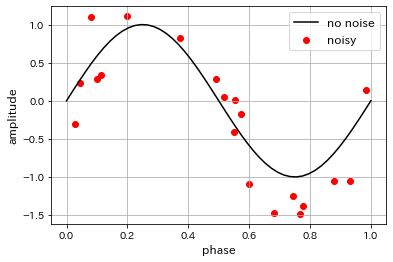

In [3]:
xs_org = np.linspace(0, 1)
xs_rand = np.random.uniform(0, 1, 20)

ys_org =  np.sin(xs_org * (2 * np.pi))
ys_noisy = np.sin(xs_rand * (2 * np.pi)) + np.random.normal(0, 0.5, len(xs_rand))

fig = plt.figure()

plt.plot(xs_org, ys_org, c='black', label='no noise')
plt.scatter(xs_rand, ys_noisy, c='red', label='noisy')
plt.xlabel('phase', fontsize=12)
plt.ylabel('amplitude', fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.show()
plt.close()

## 計画行列を用いて回帰

In [4]:
def generate_line(xs, w):
    ys_calc = np.zeros(xs.shape[0])
    for i in range(len(w)):
        ys_calc += w[i] * xs ** i      
    return ys_calc


def AIC(ys_actual, ys_pred, num_feature):
    num_data = len(ys_actual)
    mse = MSE(ys_actual, ys_pred)
    
    return num_data * np.log(2 * np.pi) + num_data * np.log(mse) + num_data + 2 * (num_feature + 2)

### 特定の次数までの多項式で会期

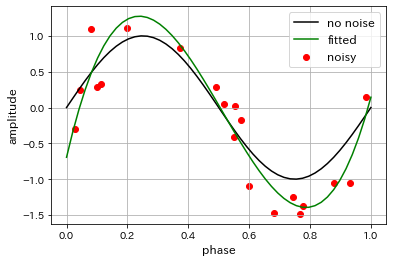

In [5]:
order = 3
pm = np.zeros((len(xs_rand), order + 1))
for i in range(len(xs_rand)):
    for j in range(order + 1):
        pm[i, j] = xs_rand[i] ** j
        
pm_T = pm.T
pseud_pm_inv = np.linalg.inv(np.dot(pm_T, pm))
W = pseud_pm_inv.dot(pm_T).dot(ys_noisy)

ys_pred = generate_line(xs_org, W)
fig = plt.figure()
plt.plot(xs_org, ys_org, c='black', label='no noise')
plt.plot(xs_org, ys_pred, c='green', label='fitted')
plt.scatter(xs_rand, ys_noisy, c='red', label='noisy')
plt.xlabel('phase', fontsize=12)
plt.ylabel('amplitude', fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.show()
plt.close()

### 検証データセット作成

In [6]:
xs_test = np.random.uniform(0, 1, 20)
ys_test = np.sin(xs_test * (2 * np.pi)) + np.random.normal(0, 0.5, len(xs_test))

### 様々な次数の多項式で回帰

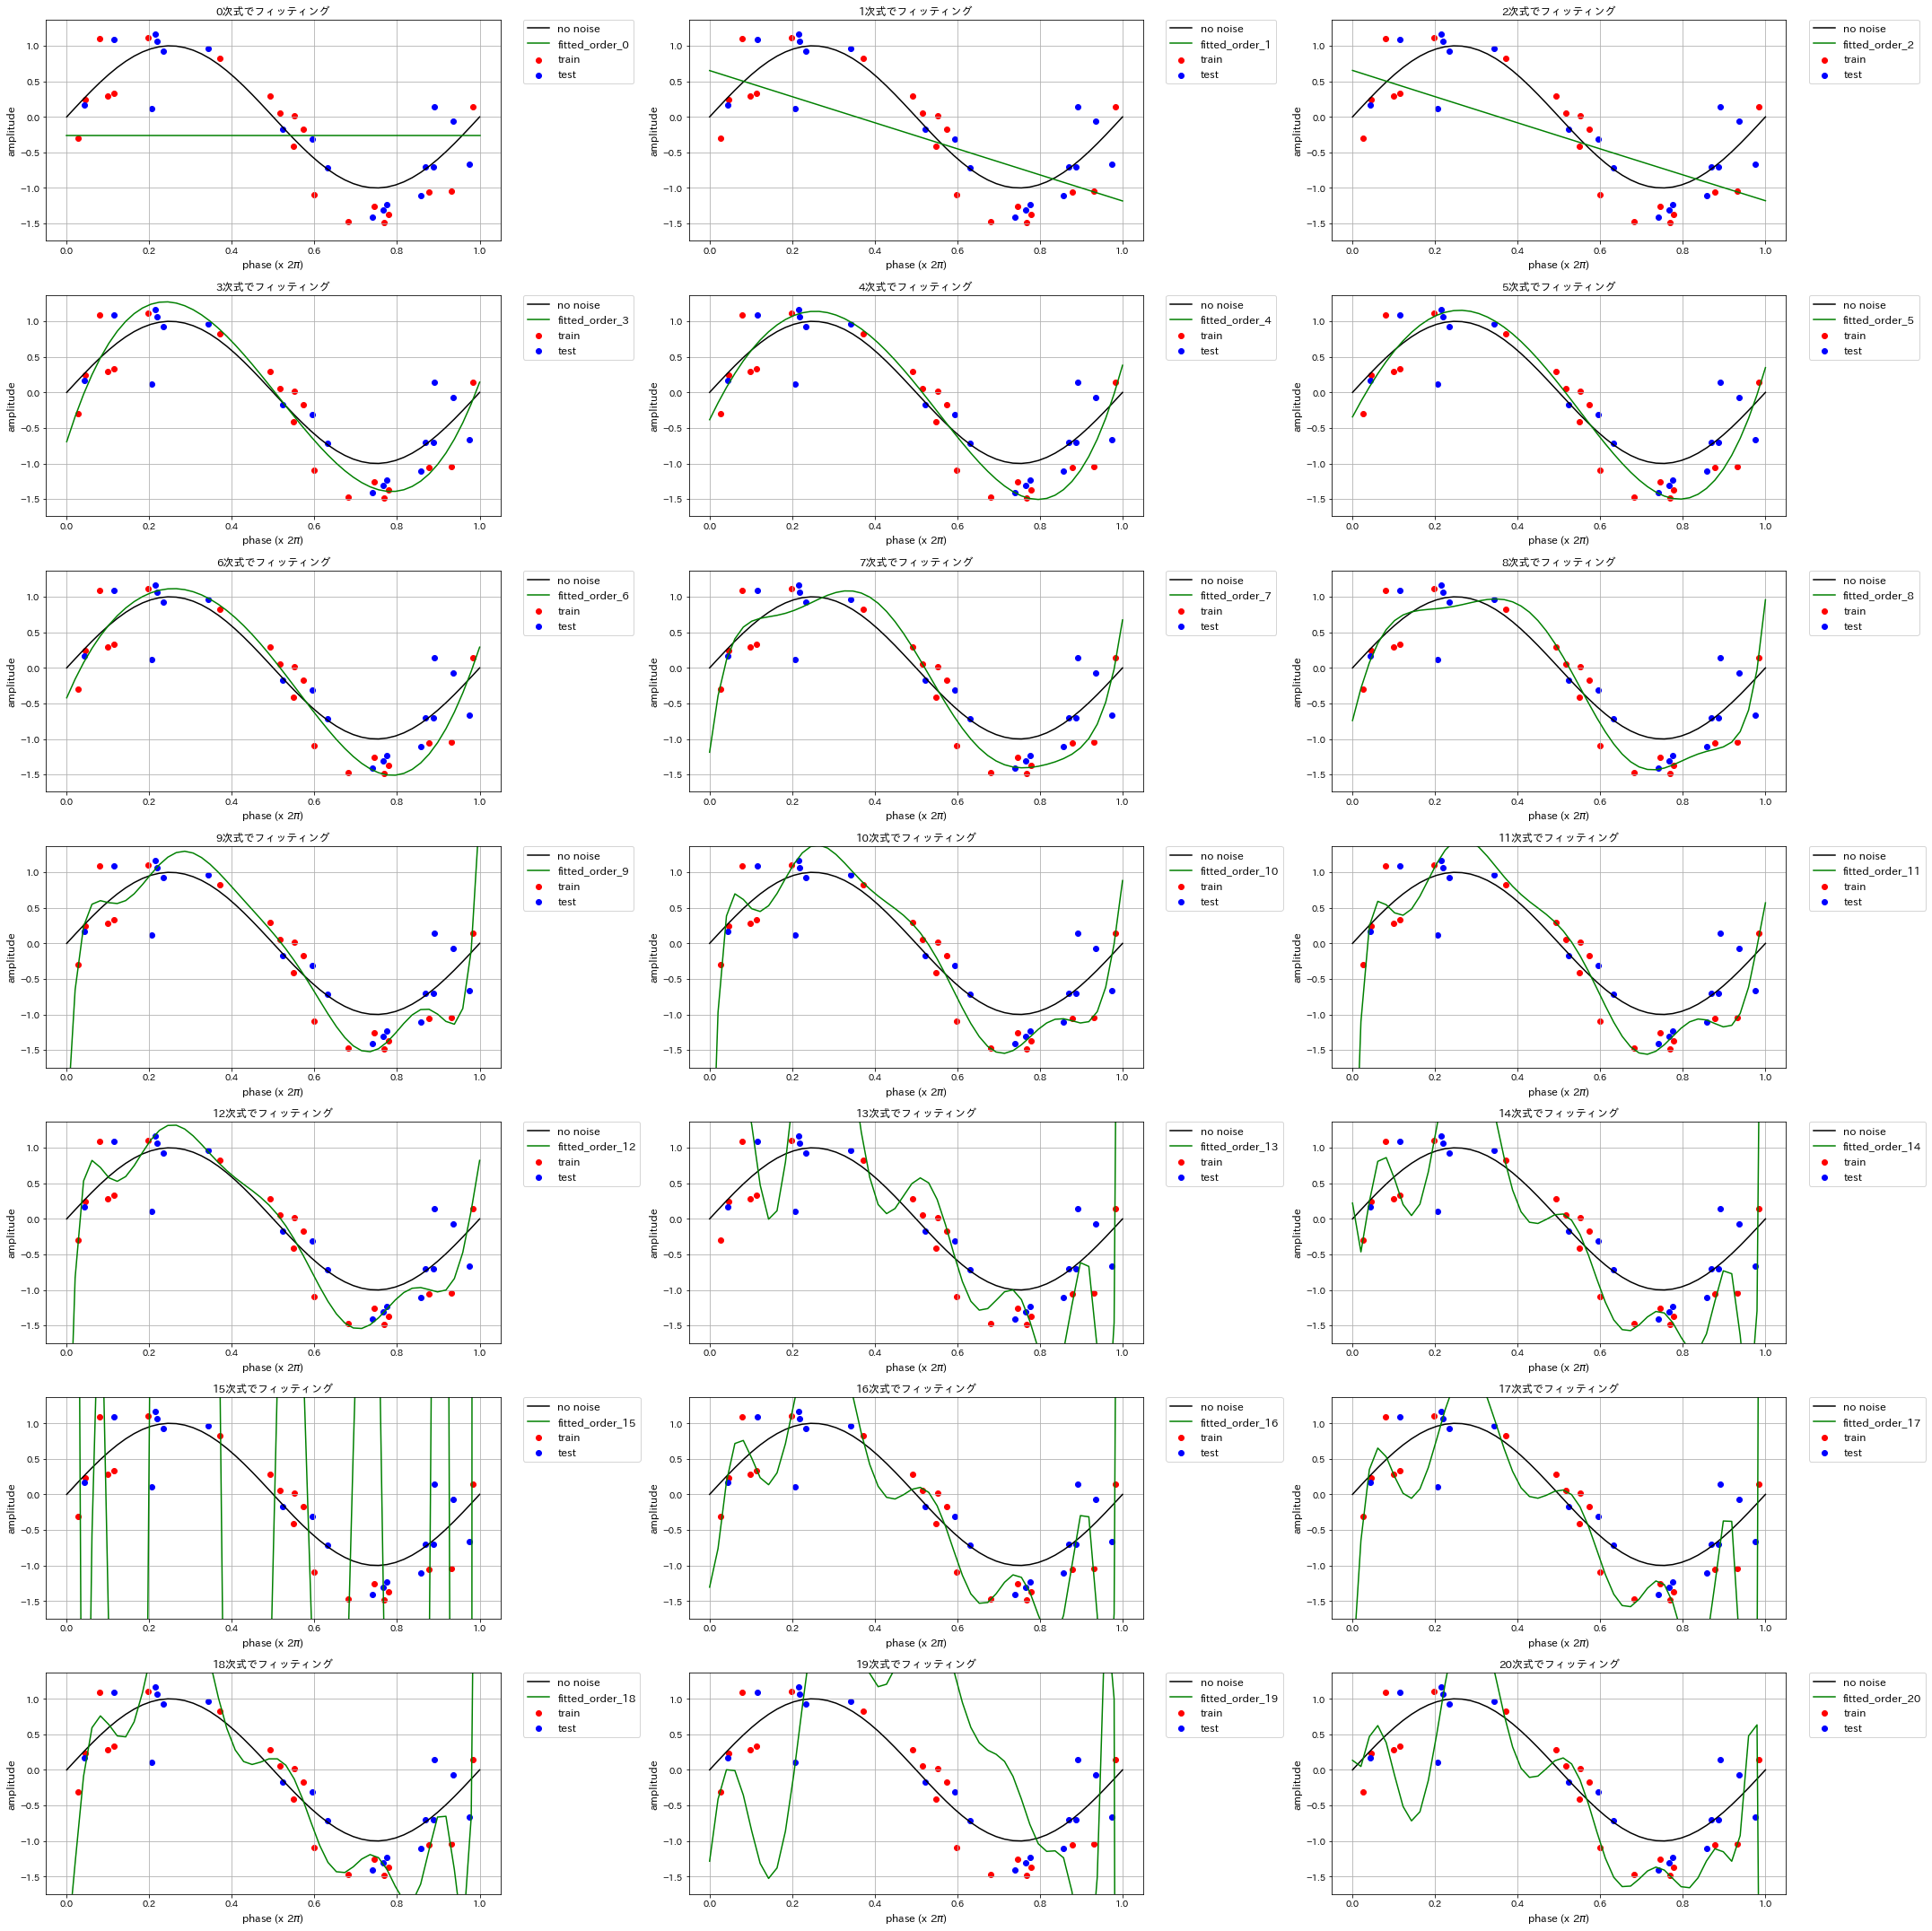

In [7]:
min_order = 0
max_order = 20
rmse_train = list() 
rmse_test = list()
aics_train = list() 
aics_test = list()

delta_ys = ys_noisy.max() - ys_noisy.min()
num_cols = 3
fig, axes = plt.subplots(ceil((max_order - min_order) / num_cols), num_cols, figsize=(30, 30))
for idx, order in enumerate(range(min_order, max_order + 1)):
    pm = np.zeros((len(xs_rand), order + 1))
    for i in range(len(xs_rand)):
        for j in range(order + 1):
            pm[i, j] = xs_rand[i] ** j
        
    pm_T = pm.T
    pseud_pm_inv = np.linalg.inv(np.dot(pm_T, pm))
    W = pseud_pm_inv.dot(pm_T).dot(ys_noisy)
    ys_pred = generate_line(xs_org, W)
    ys_pred_train = generate_line(xs_rand, W)
    ys_pred_test = generate_line(xs_test, W)
    
    aics_train.append(AIC(ys_noisy, ys_pred_train, order))
    aics_test.append(AIC(ys_test, ys_pred_test, order))    
    
    rmse_train.append(sqrt(MSE(ys_noisy, ys_pred_train)))
    rmse_test.append(sqrt(MSE(ys_test, ys_pred_test)))
    axes[idx // num_cols][idx % num_cols].plot(xs_org, ys_org, c='black', label='no noise')
    axes[idx // num_cols][idx % num_cols].plot(xs_org, ys_pred, c='green', label=f'fitted_order_{order}')
    axes[idx // num_cols][idx % num_cols].scatter(xs_rand, ys_noisy, c='red', label='train')
    axes[idx // num_cols][idx % num_cols].scatter(xs_test, ys_test, c='blue', label='test')
    axes[idx // num_cols][idx % num_cols].set_title(f'{order}次式でフィッティング', fontsize=12)
    axes[idx // num_cols][idx % num_cols].set_xlabel('phase (x 2$\pi$)', fontsize=12)
    axes[idx // num_cols][idx % num_cols].set_ylabel('amplitude', fontsize=12)
    axes[idx // num_cols][idx % num_cols].set_ylim([ys_noisy.min() - 0.1 * delta_ys, ys_noisy.max() + 0.1 * delta_ys])
    axes[idx // num_cols][idx % num_cols].grid()
    axes[idx // num_cols][idx % num_cols].legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()
plt.close()
    

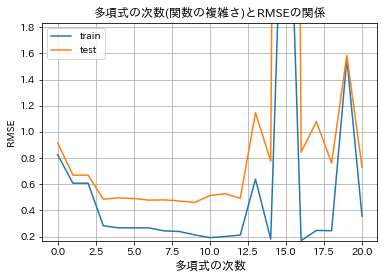

In [8]:
fig = plt.figure()
plt.plot(rmse_train, label='train')
plt.plot(rmse_test, label='test')
plt.title('多項式の次数(関数の複雑さ)とRMSEの関係', fontsize=12)
plt.xlabel('多項式の次数', fontsize=12)
plt.ylabel('RMSE')
plt.legend()
plt.ylim([min(min(rmse_train), min(rmse_test)), max(rmse_train[0], rmse_test[0]) * 2])
plt.grid()
plt.show()
plt.close()

- testセットについては8~9次式までしか改善が見られない
- 元のsin関数との形状比較では6次式までしかsin関数の再現が見られない

**人の目で多項式の次数を決めるのでは6次式となりそうだが、この次数決めを機械的に(計算機で)行うための指標がAIC, BICというような情報量基準である**

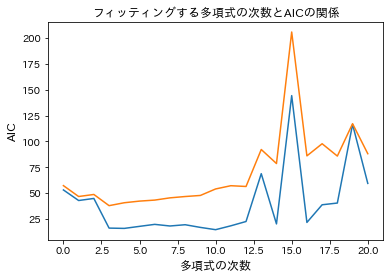

trainセットの最小AIC: 14.60272465427154, 多項式の次数: 10
testセットの最小AIC: 37.85712409747052, 多項式の次数: 3


In [9]:
fig = plt.figure()
plt.plot(aics_train, label='train')
plt.plot(aics_test, label='test')
plt.xlabel('多項式の次数', fontsize=12)
plt.ylabel('AIC', fontsize=12)
plt.title('フィッティングする多項式の次数とAICの関係', fontsize=12)
plt.show()
plt.close()

print(f'trainセットの最小AIC: {min(aics_train)}, 多項式の次数: {np.argmin(aics_train)}')
print(f'testセットの最小AIC: {min(aics_test)}, 多項式の次数: {np.argmin(aics_test)}')

このデータについてはtestセットの次数3に合わせるのが汎化性能が良さそうです。